<a href="https://colab.research.google.com/github/SourCherries/VAE-GAN-CelebA/blob/master/explore_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [1]:
# Download Tensorflow checkpoint
! gdown --id 1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV
To: /content/vaegan_celeba.ckpt
100% 555M/555M [00:05<00:00, 105MB/s]


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!git clone https://github.com/SourCherries/VAE-GAN-CelebA.git

Cloning into 'VAE-GAN-CelebA'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 135 (delta 28), reused 8 (delta 3), pack-reused 72
Receiving objects: 100% (135/135), 1.50 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
import sys, getopt
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher.\n')
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [5]:
sys.path

['/tensorflow-1.15.2/python3.7',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [6]:
sys.path.insert(0,'/content/VAE-GAN-CelebA/libs')
sys.path.insert(0,'/content/VAE-GAN-CelebA/')

In [107]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import libs.make_network as make_network
import libs.utils as utils
from scipy.io import loadmat, savemat
import imageio
from skimage.util import montage
import pandas as pd
import seaborn as sns


print('TF version = ',tf.__version__)

# Can do this with placeholders used by RVR
# tf.compat.v1.enable_eager_execution()

TF version =  1.15.2


In [8]:
file = "/content/VAE-GAN-CelebA/example.jpg"
print ('Input file is ', file)

Input file is  /content/VAE-GAN-CelebA/example.jpg


In [9]:
sess, X, G, Z, Z_mu, is_training, saver = make_network.make_network()




encoder/input: [None, 128, 128, 3]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

layer: 0 , shape: [None, 64, 64, 192]
layer: 1 , shape: [None, 32, 32, 256]
layer: 2 , shape: [None, 16, 16, 384]
layer: 3 , shape: [None, 8, 8, 512]
layer: 4 , shape: [None, 4, 4, 768]


Instructions for updating:
Use `tf.global_variables_initializer` instead.

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [10]:
# ZM = tf.identity(Z_mu)
#with tf.Session() as sess:
#      result = sess.run(Z_mu)
print(tf.math.minimum(Z_mu, 0))
print(tf.math.maximum(Z_mu, 0))

Tensor("Minimum:0", shape=(?, 1024), dtype=float32)
Tensor("Maximum:0", shape=(?, 1024), dtype=float32)


In [11]:
if os.path.exists("vaegan_celeba.ckpt"):
    saver.restore(sess, "vaegan_celeba.ckpt")
    print("VAE-GAN model restored.")
else:
    print("Pre-trained network appears to be missing.")
    sys.exit()

INFO:tensorflow:Restoring parameters from vaegan_celeba.ckpt
VAE-GAN model restored.


# Image to latent space

In [12]:
img = plt.imread(file)[..., :3]
print(img.shape)

img = utils.preprocess128(img,crop_factor=0.8)[np.newaxis]
print(img.shape)

(218, 178, 3)
(1, 128, 128, 3)


In [13]:
# generate z from images
z = sess.run(Z_mu, feed_dict={X: img, is_training: False})

In [14]:
# save data in Matlab format
savemat(file[:-4]+'_z',dict(latent=z))

(1, 1024)


(array([335.,  71.,  40.,  34.,  38.,  35.,  30.,  52.,  55., 334.]),
 array([-9.9999839e-01, -7.9999864e-01, -5.9999889e-01, -3.9999917e-01,
        -1.9999942e-01,  3.2782555e-07,  2.0000008e-01,  3.9999983e-01,
         5.9999955e-01,  7.9999930e-01,  9.9999905e-01], dtype=float32),
 <a list of 10 Patch objects>)

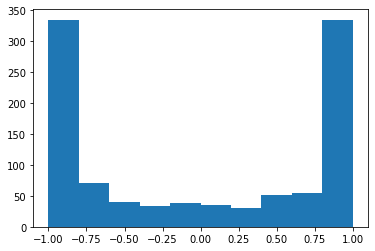

In [15]:
print(z.shape)
plt.hist(z.squeeze())

# Latent space to image

In [16]:
latent_file = "/content/VAE-GAN-CelebA/example_z"
print ('Input file is "', latent_file)

Input file is " /content/VAE-GAN-CelebA/example_z


In [51]:
sess, X, G, Z, Z_mu, is_training, saver = make_network.make_network()
if os.path.exists("vaegan_celeba.ckpt"):
    saver.restore(sess, "vaegan_celeba.ckpt")
    print("VAE-GAN model restored.")
else:
    print("Pre-trained network appears to be missing.")
    sys.exit()

encoder/input: [None, 128, 128, 3]
layer: 0 , shape: [None, 64, 64, 192]
layer: 1 , shape: [None, 32, 32, 256]
layer: 2 , shape: [None, 16, 16, 384]
layer: 3 , shape: [None, 8, 8, 512]
layer: 4 , shape: [None, 4, 4, 768]


INFO:tensorflow:Restoring parameters from vaegan_celeba.ckpt


INFO:tensorflow:Restoring parameters from vaegan_celeba.ckpt


VAE-GAN model restored.


In [18]:
latent = loadmat(latent_file)['latent'] #make sure that the matlab variable name is 'latent'
print('input data to be transformed:',latent.shape)
if latent.shape[0]==1024:
    latent=latent[np.newaxis]
elif latent.shape[1]!=1024:
    print("None of the input dimensions appears to be 1024!!!")

input data to be transformed: (1, 1024)


In [21]:
# generate images from z
g = sess.run(G, feed_dict={Z: (1*latent), is_training: False})

In [20]:
def imdeprocess(g):
    stretch = 1.0
    for i in range(g.shape[0]):
        g[i]=np.clip(stretch*g[i] / (g.max()),0,1)
    return g

In [22]:
g=imdeprocess(g)

In [23]:
#if there's only one image, we save it as a jpg
if g.shape[0]==1:
    plt.imsave(file[:-4]+'_g.jpg',g[0])

In [24]:
#in all cases, we save the image(s) as a .mat file
savemat(file[:-4]+'_g',dict(images=g))

# Encoding is truly stochastic?

Latent vector different for 2 encodings of the same image.

In [27]:
za = sess.run(Z_mu, feed_dict={X: img, is_training: False})
zb = sess.run(Z_mu, feed_dict={X: img, is_training: False})

In [28]:
percent_exact_match = (za==zb).sum() * 100 / 1024
print(percent_exact_match)

0.0


Examine distribution across encodings of same image separately for different dimensions of Z.

In [29]:
iterations = 1000
M = np.zeros((iterations, 1024))
for i in range(iterations):
  M[i,:] = sess.run(Z_mu, feed_dict={X: img, is_training: False})


<function matplotlib.pyplot.show>

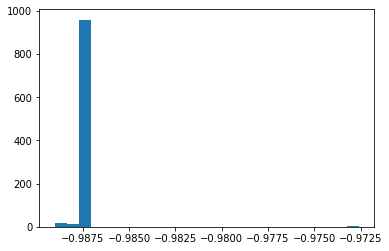

In [30]:
plt.hist(M[:,1], bins=25); plt.show

<function matplotlib.pyplot.show>

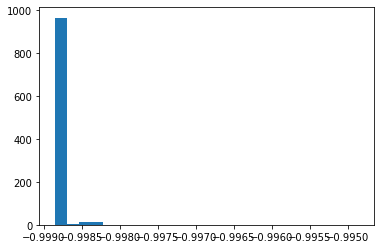

In [ ]:
plt.hist(M[:,2], bins=25); plt.show

<function matplotlib.pyplot.show>

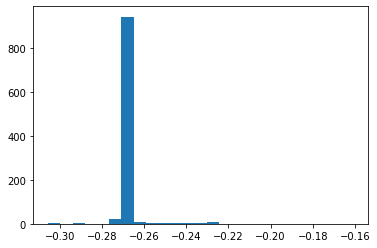

In [ ]:
plt.hist(M[:,4], bins=25); plt.show

<function matplotlib.pyplot.show>

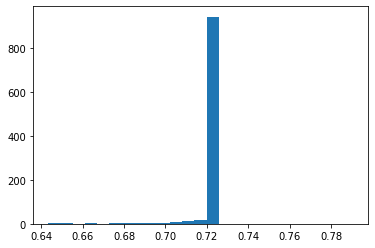

In [ ]:
plt.hist(M[:,8], bins=25); plt.show

<function matplotlib.pyplot.show>

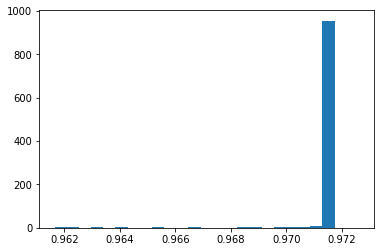

In [ ]:
plt.hist(M[:,16], bins=25); plt.show

<function matplotlib.pyplot.show>

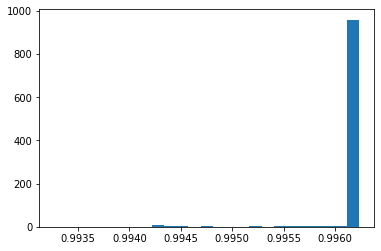

In [ ]:
plt.hist(M[:,32], bins=25); plt.show

<function matplotlib.pyplot.show>

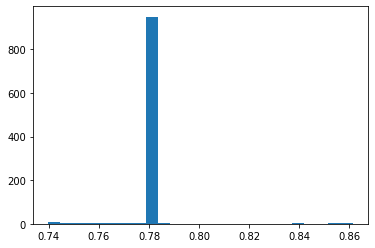

In [ ]:
plt.hist(M[:,64], bins=25); plt.show

<function matplotlib.pyplot.show>

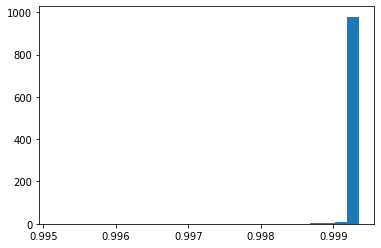

In [ ]:
plt.hist(M[:,128], bins=25); plt.show

<function matplotlib.pyplot.show>

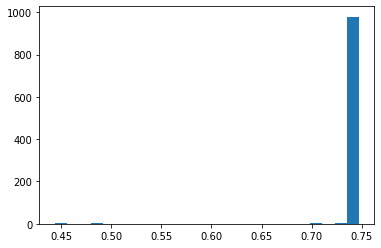

In [ ]:
plt.hist(M[:,512], bins=25); plt.show

<function matplotlib.pyplot.show>

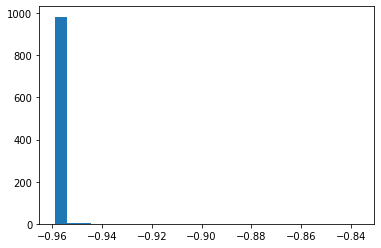

In [ ]:
plt.hist(M[:,1023], bins=25); plt.show

Not priority. Visualize variation in encoding using a gif of decoded images, using [this code](https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python).

# Network variation in encoding visualized as corresponding decoding

In [31]:
imgb = plt.imread("/content/VAE-GAN-CelebA/201475.jpg")[..., :3]
imgb = utils.preprocess128(imgb, crop_factor=0.8)[np.newaxis]

images = []
n_faces = 55 * 3
for i in range(n_faces):
  zb = sess.run(Z_mu, feed_dict={X: imgb, is_training: False})
  g = sess.run(G, feed_dict={Z: (1*zb), is_training: False})
  g = imdeprocess(g)
  images.append(g[0])  

imageio.mimsave('201475-encoding-variation.gif', images)

# Examine images of latents sampled from standard normal distribution

In [32]:
L = np.random.standard_normal((25, 1024)) * 0.2

In [33]:
images = []
for i in range(25):
  g = sess.run(G, feed_dict={Z: (1*L[i,:].reshape((1,1024))), is_training: False})
  g = imdeprocess(g)
  images.append(g[0])

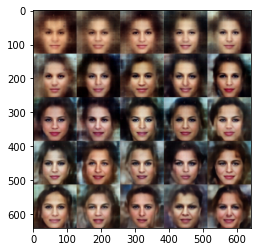

In [34]:
images_arr = montage(images, multichannel=True)
plt.imshow(images_arr)

In [ ]:
g[0].shape

(128, 128, 3)

# Interpolate real faces

Face A from Celeb A dataset.

In [35]:
imga = plt.imread("/content/VAE-GAN-CelebA/200475.jpg")[..., :3]
imga = utils.preprocess128(imga, crop_factor=0.8)[np.newaxis]
za = sess.run(Z_mu, feed_dict={X: imga, is_training: False})

Face B from Celeb A dataset

In [36]:
imgb = plt.imread("/content/VAE-GAN-CelebA/201475.jpg")[..., :3]
imgb = utils.preprocess128(imgb, crop_factor=0.8)[np.newaxis]
zb = sess.run(Z_mu, feed_dict={X: imgb, is_training: False})

Interpolation between A and B

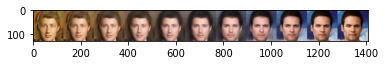

In [38]:
images = []
n_faces = 11
p = [i/(n_faces-1) for i in range(n_faces)]
for i in range(n_faces):
  z = zb*p[i] + (za-zb)*(1-p[i])  # from face a to b
  # generate images from z
  g = sess.run(G, feed_dict={Z: (1*z), is_training: False})
  g = imdeprocess(g)
  images.append(g[0])
images_arr = montage(images, grid_shape=(1, n_faces), multichannel=True)
plt.imshow(images_arr)
plt.imsave('200475-201475.jpg', images_arr)

Interpolation (top row) and interpolation with noise (subsequent rows).

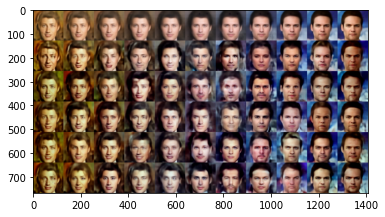

In [39]:
n_rows = 5
for r in range(n_rows):
  for i in range(n_faces):
    z = zb*p[i] + (za-zb)*(1-p[i])  # from face a to b
    noise = np.random.standard_normal(size=(1, 1024)) * .8
    z = z + noise

    # z[z > 1] = 1
    # z[z < 0] = 0

    # generate images from z
    g = sess.run(G, feed_dict={Z: (1*z), is_training: False})
    g = imdeprocess(g)
    images.append(g[0])
images_arr = montage(images, grid_shape=(1 + n_rows, n_faces), multichannel=True)
plt.imshow(images_arr)
plt.imsave('200475-201475-noise.jpg', images_arr)

In [40]:
images = []
n_faces = 11 * 5
p = [i/(n_faces-1) for i in range(n_faces)]
for i in range(n_faces):
  z = zb*p[i] + (za-zb)*(1-p[i])  # from face a to b
  # generate images from z
  g = sess.run(G, feed_dict={Z: (1*z), is_training: False})
  g = imdeprocess(g)
  images.append(g[0])

imageio.mimsave('200475-201475.gif', images)

# Image processing to equate endpoints along low-level characteristics?
Histogram equalization for example.

# Distribution of Z across Celeb A training faces

In [41]:
! gdown --id 1cMNezwqQoDPsFlWvWxDNivIGVoQBtPEu  # single file

# Works with single file and editing allowed

# How can I download a whole folder?


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cMNezwqQoDPsFlWvWxDNivIGVoQBtPEu
To: /content/019993.jpg
100% 7.28k/7.28k [00:00<00:00, 8.50MB/s]


In [42]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# !cp -r '/content/gdrive/My Drive/celeb-a-1-1' 'celeb-a-1-1'

# This seems unnecessary as gdrive/MyDrive/ naturally appears under /content
# Entire gdrive mounted!

In [ ]:
file_dir = "/content/gdrive/MyDrive/celeb-a-1-1/"
ida = 10000
idb = 19999
n_faces = 10000
z_many = np.zeros((n_faces, 1024))
ind = 0
from tqdm import tqdm

# for i in range(ida, idb + 1):
for i in tqdm(range(ida, idb + 1)):  
  # file_name = int((6 - np.log10(i))) * "0" + str(i) + ".jpg"
  file_name = "0" + str(i) + ".jpg"
  file_full = file_dir + file_name
  img = plt.imread(file_full)[..., :3]
  img = utils.preprocess128(img, crop_factor=0.8)[np.newaxis]
  z = sess.run(Z_mu, feed_dict={X: img, is_training: False})  
  z_many[ind, :] = z
  ind += 1


100%|██████████| 10000/10000 [1:43:14<00:00,  1.61it/s]


In [ ]:
# z_many.shape
# numpy.save(file, arr, allow_pickle=True, fix_imports=True)
np.save("z_10000_celeba.npy", arr=z_many)

(array([3177.,  557.,  430.,  353.,  319.,  297.,  355.,  451.,  579.,
        3482.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

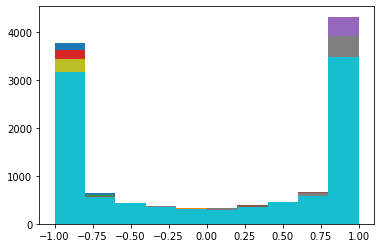

In [ ]:
plt.hist(z_many[:, 0])
plt.hist(z_many[:, 2])
plt.hist(z_many[:, 4])
plt.hist(z_many[:, 16])
plt.hist(z_many[:, 32])
plt.hist(z_many[:, 64])
plt.hist(z_many[:, 128])
plt.hist(z_many[:, 256])
plt.hist(z_many[:, 512])
plt.hist(z_many[:, 1023])

(array([3786.,  634.,  441.,  362.,  322.,  285.,  305.,  381.,  564.,
        2920.]),
 array([-1.00000000e+00, -7.99999988e-01, -5.99999976e-01, -3.99999964e-01,
        -1.99999952e-01,  5.96046448e-08,  2.00000072e-01,  4.00000083e-01,
         6.00000095e-01,  8.00000107e-01,  1.00000012e+00]),
 <a list of 10 Patch objects>)

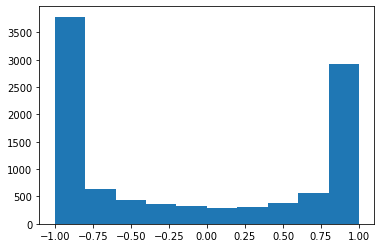

In [ ]:
plt.hist(z_many[:, 0])

array([[1.        , 0.0184165 , 0.04165321, ..., 0.0204495 , 0.00179029,
        0.09935726],
       [0.0184165 , 1.        , 0.01459624, ..., 0.15615231, 0.00568442,
        0.04498135],
       [0.04165321, 0.01459624, 1.        , ..., 0.07569633, 0.04167637,
        0.02630176],
       ...,
       [0.0204495 , 0.15615231, 0.07569633, ..., 1.        , 0.06554124,
        0.02199954],
       [0.00179029, 0.00568442, 0.04167637, ..., 0.06554124, 1.        ,
        0.05548494],
       [0.09935726, 0.04498135, 0.02630176, ..., 0.02199954, 0.05548494,
        1.        ]])

In [ ]:
np.abs(np.triu(np.corrcoef(z_many, rowvar=False), 1)).max()

0.8578282724501214

In [ ]:
V = np.ones((5,5))
locs = np.triu(np.ones((5,5)), 1)>0
V[locs].shape


C = np.corrcoef(z_many, rowvar=False)
locs = np.triu(np.ones((1024, 1024)), 1) > 0
c = C[locs]



(array([2.40000e+01, 9.00000e+01, 2.89000e+02, 3.30000e+03, 2.83747e+05,
        2.33601e+05, 2.38700e+03, 2.51000e+02, 6.70000e+01, 2.00000e+01]),
 array([-0.84383613, -0.67366969, -0.50350325, -0.33333681, -0.16317037,
         0.00699607,  0.17716251,  0.34732895,  0.51749539,  0.68766183,
         0.85782827]),
 <a list of 10 Patch objects>)

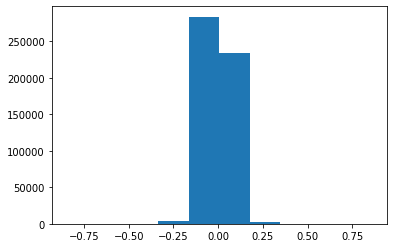

In [ ]:
plt.hist(c)

# Extrapolate real faces

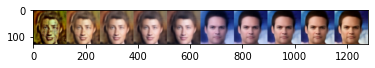

In [43]:
images = []
p = [-i/8 for i in range(5).__reversed__()] + [1 + i/8 for i in range(5)]
for i in range(10):
  z = zb*p[i] + (za-zb)*(1-p[i])  # from face a to b
  # generate images from z
  g = sess.run(G, feed_dict={Z: (1*z), is_training: False})
  g = imdeprocess(g)
  images.append(g[0])
images_arr = montage(images, grid_shape=(1, 10), multichannel=True)
plt.imshow(images_arr)
plt.imsave('200475-201475-extrapolate.jpg', images_arr)

# Distribution of latent values for face at midpoint

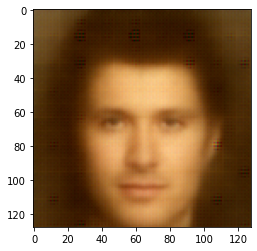

In [44]:
p = 0.5
z = zb*p + (za-zb)*(1-p)  # from face a to b
# generate images from z
g = sess.run(G, feed_dict={Z: (1*z), is_training: False})
g = imdeprocess(g)
img_mid = g[0]
plt.imshow(img_mid)

(array([292.,  53.,  42.,  52.,  37.,  37.,  29.,  45.,  73., 364.]),
 array([-9.9999988e-01, -7.9999989e-01, -5.9999990e-01, -3.9999992e-01,
        -1.9999993e-01,  5.9604645e-08,  2.0000005e-01,  4.0000004e-01,
         6.0000002e-01,  8.0000001e-01,  1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

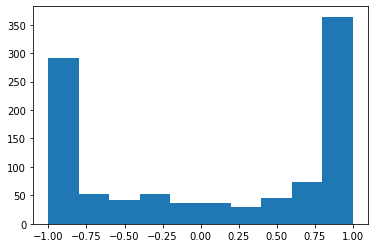

In [45]:
z = sess.run(Z_mu, feed_dict={X: g, is_training: False})
plt.hist(z.squeeze())

In [46]:
(z.min(), z.max())

(-0.9999999, 1.0)

# Mean person in latent space
* Z with more density away from boundaries?
* Decoded image looks good?
* Decoded image with fewer artefacts?

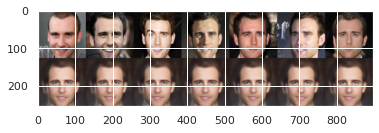

In [108]:
# Get list of all images and z for person 6576
dir_images = "/content/gdrive/MyDrive/celeb-a-1-1/"
files = pd.read_csv("/content/VAE-GAN-CelebA/person-6576-files.csv", header=None)
img_arr = []
M = np.zeros((7, 1024))
ind = 0
for f in files[0]:
  img = plt.imread(dir_images + f)
  img = utils.preprocess128(img[..., :3], crop_factor=0.8)[np.newaxis]
  img_arr.append(img[0,...])
  z = sess.run(Z_mu, feed_dict={X: img, is_training: False})  
  M[ind, :] = z
  ind += 1  

# Mean z
z_mu = M.mean(axis=0)
if z_mu.shape[0]==1024:
    z_mu = z_mu[np.newaxis]
elif z_mu.shape[1]!=1024:
    print("None of the input dimensions appears to be 1024!!!")

# Decoded mean z together with instances in montage
g = sess.run(G, feed_dict={Z: (1*z_mu), is_training: False})
g = imdeprocess(g)
img_mean_z = g[0]
for i in range(7):
  img_arr.append(img_mean_z)
img_mont = montage(img_arr, multichannel=True, grid_shape=(2, 7))
plt.imshow(img_mont)
plt.imsave('instances-vs-mean-z-6576.jpg', img_mont)


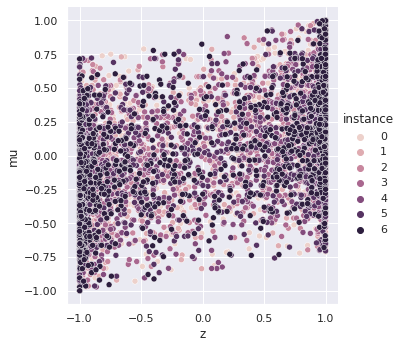

In [109]:
# Distribution of mean z compared with z of instances

# Set up data frame to visualize
#   z_mu, M -> DataFrame: mu (rep), instance, z
df_id = np.repeat(np.arange(7), repeats=1024)

df_mu = np.tile(z_mu, 7).flatten()

df_z = pd.DataFrame({"mu": df_mu,
                     "instance": df_id,
                     "z": M.flatten(order="C")})

# Plot
sns.relplot(x="z", y="mu", hue="instance", data=df_z)

# Midpoint between two person means?
* Z with even more density away from boundaries?
* Decoded image looks good?
* No need to worry about background!